In [51]:
import pandas as pd

print("--- Starting Merge Process ---")

try:
    # Load both original CSVs
    df_annotations = pd.read_csv("content/annotations.csv")
    df_bbox = pd.read_csv("content/bbox.csv")
    merged_path = "content/merged_turtle_data.csv"

    print("Loaded annotations.csv and bbox.csv")

    # Merge them
    # 'path' in annotations.csv is the same as 'image_name' in bbox.csv
    df_merged = pd.merge(df_annotations, df_bbox, left_on='path', right_on='image_name')

    print(f"Merge successful. New table has {len(df_merged)} rows.")

    # Save the new merged file
    df_merged.to_csv(merged_path, index=False)

    print("\nSuccessfully created 'merged_turtle_data.csv'!")
    print("\nColumns in new file:")
    print(df_merged.columns.to_list())

    print("\nHead of merged file:")
    print(df_merged.head())

except FileNotFoundError as e:
    print(f"Error: {e}. Make sure 'annotations.csv' and 'bbox.csv' are in your /content/ directory.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Starting Merge Process ---
Loaded annotations.csv and bbox.csv
Merge successful. New table has 160 rows.

Successfully created 'merged_turtle_data.csv'!

Columns in new file:
['identity', 'path', 'orientation', 'date', 'label_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height', 'image_name', 'image_width', 'image_height']

Head of merged file:
  identity               path orientation        date label_name  bbox_x  \
0   G16-25   leftIMG_0958.JPG        left  22_06_2018       head    1137   
1   G16-25  rightIMG_0961.JPG       right  22_06_2018       head    2764   
2   G16-25   leftIMG_1300.JPG        left  08_07_2020       head    1331   
3   G16-25  rightIMG_1280.JPG       right  08_07_2020       head    2676   
4     t551   leftIMG_1084.JPG        left  07_06_2023       head    1919   

   bbox_y  bbox_width  bbox_height         image_name  image_width  \
0     953         607          523   leftIMG_0958.JPG         5472   
1    1232         843          664  rightIMG_0961.

**Step 1: Preprocessing**

In [52]:
# def preprocess_image(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     enhanced_contrast = clahe.apply(blurred)
#     return enhanced_contrast

**Step 2: Head Detection (ROI)**

In [53]:
# def get_head_roi(image, bbox):
#     x, y, w, h = bbox
#     x, y, w, h = int(x), int(y), int(w), int(h)
#     roi = image[y:y+h, x:x+w]
#     return roi

**Step 3: Rotate (Registration)**

In [54]:
# def register_head(image, orientation, landmarks):
#     """
#     Registers a head image and its corresponding landmarks.
#     If orientation is 'right', it flips both the image and 
#     the landmarks horizontally.
#     """
#     landmarks = np.asarray(landmarks)
    
#     if orientation == 'right':
#         # 1. Flip image
#         registered_image = cv2.flip(image, 1)
#         # 2. Get width
#         image_width = image.shape[1]
#         # 3. Copy landmarks
#         registered_landmarks = np.copy(landmarks)
#         # 4. Flip x-coordinate
#         registered_landmarks[:, 0] = (image_width - 1) - registered_landmarks[:, 0]
        
#         return registered_image, registered_landmarks
#     else:
#         return image, landmarks


**Step 4: Segmentation**

In [55]:
def segment_pattern(image):
    """
    Advanced segmentation สำหรับลายเต่า
    * เน้นให้ลายคม + เส้นติดกัน *
    """
 
    # 1) เพิ่ม contrast แบบรักษา texture
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(image)
 
    # 2) ลด noise แต่คงลาย
    filtered = cv2.bilateralFilter(enhanced, d=5, sigmaColor=30, sigmaSpace=30)
 
    # 3) Otsu Threshold
    _, segmented = cv2.threshold(
        filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
 
    # 4) เชื่อมเส้นลายให้ติดกัน
    kernel = np.ones((3,3), np.uint8)
    segmented = cv2.morphologyEx(segmented, cv2.MORPH_CLOSE, kernel)
 
    # 5) ทำให้ mask เรียบขึ้นนิดหนึ่ง
    segmented = cv2.GaussianBlur(segmented, (3,3), 0.3)
 
    # เติมเส้นให้ต่อเนื่องมากขึ้นแบบไม่บวมมาก
    segmented = cv2.dilate(segmented, np.ones((1,1), np.uint8), iterations=1)
 
    return segmented

In [56]:
import cv2
import numpy as np
import os

# --- Constants for Alignment (PROFILE VIEW) ---

TARGET_SIZE = (200, 200)

# Profile-view landmarks:
# [Eye, Mouth tip, Jaw base]
CANONICAL_LANDMARKS_LEFT = np.float32([
    [130, 80],   # Eye (visible one)
    [90, 140],   # Mouth tip / beak front
    [110, 170]   # Jaw base
])

CANONICAL_LANDMARKS_RIGHT = np.float32([
    [(TARGET_SIZE[0]-1)-130, 80],   # Eye
    [(TARGET_SIZE[0]-1)-90, 140],   # Mouth tip
    [(TARGET_SIZE[0]-1)-110, 170]   # Jaw base
])

# --- UPDATED LANDMARK DETECTION FUNCTION ---
def find_landmarks(roi_image):
    """
    Detects one eye and mouth/beak region in a side-view turtle head.
    Returns three points: [eye, mouth_tip, jaw_base].
    """
    hsv = cv2.cvtColor(roi_image, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)

    # --- Eye detection (dark circular area) ---
    v = hsv[:, :, 2]
    dark_mask = cv2.inRange(v, 0, 70)  # dark pixels = likely eye region
    dark_mask = cv2.morphologyEx(dark_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    contours, _ = cv2.findContours(dark_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    eye_center = None
    height, width = gray.shape
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 20 < area < 3000:
            (x, y, w, h) = cv2.boundingRect(cnt)
            if y < height * 0.7:  # avoid mouth region
                eye_center = (x + w/2, y + h/2)
                break

    if eye_center is None:
        return None

    # --- Mouth/beak detection (edge + bright area) ---
    edges = cv2.Canny(gray, 60, 150)
    lower_half = edges[int(height*0.5):, :]
    if np.count_nonzero(lower_half) == 0:
        return None
    mouth_y, mouth_x = np.unravel_index(np.argmax(lower_half), lower_half.shape)
    mouth_tip = (mouth_x, mouth_y + int(height*0.5))

    # --- Jaw base (below mouth tip) ---
    jaw_base = (mouth_tip[0] + (20 if eye_center[0] < width/2 else -20),
                mouth_tip[1] + 25)

    return np.float32([eye_center, mouth_tip, jaw_base])

# --- Image Processing Functions ---

def preprocess_image(image):
    """Applies grayscale, blur, and contrast enhancement."""
    # Check if image is already grayscale
    if len(image.shape) == 2 or image.shape[2] == 1:
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_contrast = clahe.apply(blurred)
    return enhanced_contrast

def get_head_roi(image, bbox):
    """Extracts the Region of Interest (ROI) based on the bounding box."""
    x, y, w, h = [int(v) for v in bbox]
    roi = image[y:y+h, x:x+w]
    return roi

def register_head(image_roi, detected_landmarks, target_landmarks):
    """
    Aligns a head ROI to a *specific* target landmark set.
    This function does NOT flip.
    
    :param image_roi: The cropped head image.
    :param detected_landmarks: A (3, 2) numpy array of (x, y) coordinates
                               found on the image_roi.
    :param target_landmarks: The canonical landmark set to align to
                             (e.g., CANONICAL_LANDMARKS_LEFT or _RIGHT).
    :return: A new image, aligned and resized to TARGET_SIZE.
    """
    
    # Ensure landmarks are float32
    src_landmarks = np.float32(detected_landmarks)
    
    # Calculate the transformation matrix
    M = cv2.getAffineTransform(src_landmarks, target_landmarks)
    
    # Apply the affine transformation
    aligned_image = cv2.warpAffine(
        image_roi,
        M,
        TARGET_SIZE,
        borderMode=cv2.BORDER_REPLICATE
    )
    
    return aligned_image

In [57]:
def debug_landmarks(image, landmarks):
    img_debug = image.copy()
    for (x, y) in landmarks:
        cv2.circle(img_debug, (int(x), int(y)), 5, (0, 255, 0), -1)
    return img_debug

**Demostration**

In [58]:
import pandas as pd
import numpy as np
import cv2  # OpenCV library
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- Define paths ---
IMAGE_DIR = "content/images/"
CSV_FILE = "content/merged_turtle_data.csv"

# --- Load the MERGED metadata into the 'df' variable ---
try:
    df = pd.read_csv(CSV_FILE)
    print(f"✅ Successfully loaded {CSV_FILE} with {len(df)} records.")
except FileNotFoundError:
    print(f"❌ ERROR: Could not find {CSV_FILE}.")
    print("Please make sure you ran Step A first.")
except Exception as e:
    print(f"⚠️ An error occurred loading the CSV: {e}")

✅ Successfully loaded content/merged_turtle_data.csv with 160 records.


--- Running 4 Random Turtle Pipeline Examples ---


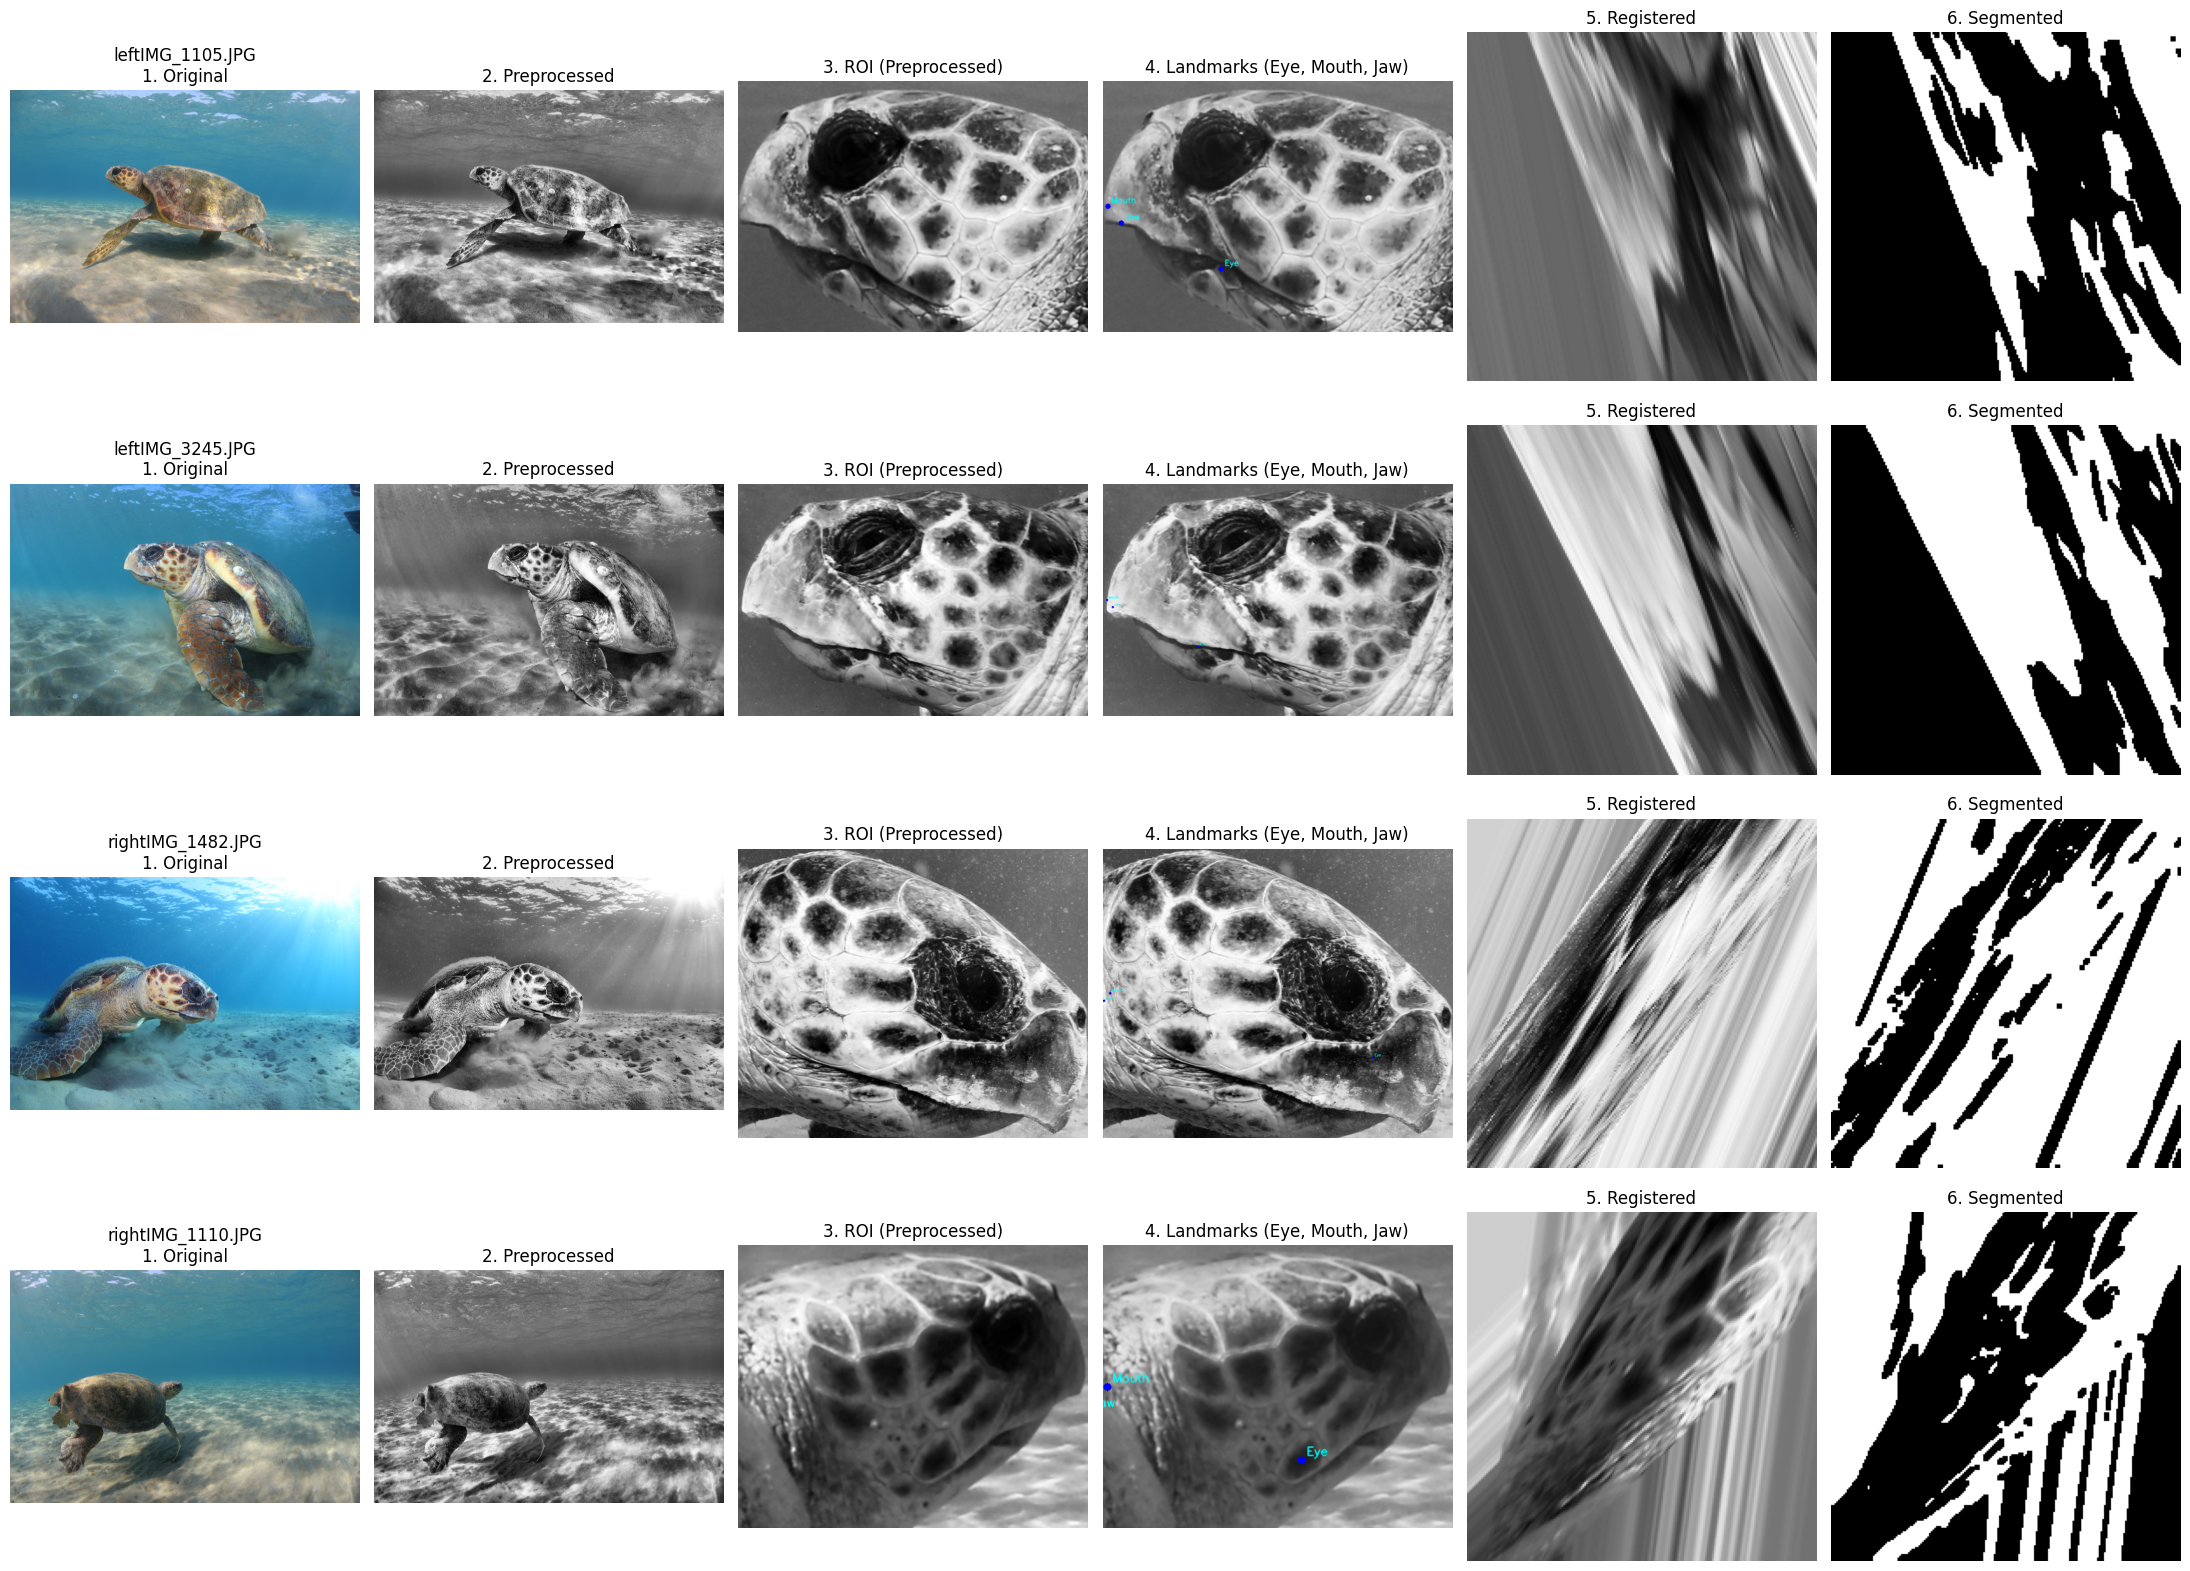

✅ Saved 'pipeline_4_examples_profile_turtles.png'


In [59]:
import random
import matplotlib.pyplot as plt

# --- UPDATED DEMONSTRATION FUNCTION ---
def demonstrate_pipeline(row):
    """
    Runs one image through the full pipeline (Steps 1–5)
    and returns intermediate images (ROI, landmarks, registered, segmented)
    for visualization.
    """
    results = {"name": None, "roi_color": None, "roi_with_landmarks": None, 
               "registered": None, "segmented": None}

    try:
        image_name = row['image_name']
        image_path = os.path.join(IMAGE_DIR, image_name)
        orientation = row['orientation']
        bbox = [row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']]
        results["name"] = image_name

        # --- 1️⃣ Load original ---
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"⚠️ Could not load image {image_path}")
            return None
        results["original"] = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # --- 2️⃣ Preprocess full image ---
        preprocessed_full = preprocess_image(original_image)
        results["preprocessed"] = preprocessed_full

        # --- 3️⃣ Extract ROI from preprocessed ---
        roi_gray = get_head_roi(preprocessed_full, bbox)
        roi_color = get_head_roi(original_image, bbox)
        results["roi"] = roi_gray

        # --- 4️⃣ Find landmarks ---
        detected_landmarks = find_landmarks(roi_color)
        if detected_landmarks is None:
            print(f"⚠️ No landmarks found for {image_name}")
            return None

        # Draw landmarks + labels
        roi_vis = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2BGR)
        labels = ["Eye", "Mouth", "Jaw"]
        for (pt, label) in zip(detected_landmarks, labels):
            x, y = int(pt[0]), int(pt[1])
            cv2.circle(roi_vis, (x, y), 4, (255, 0, 0), -1)
            cv2.putText(
                roi_vis, label, (x + 5, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1, cv2.LINE_AA
            )
        results["roi_landmarks"] = cv2.cvtColor(roi_vis, cv2.COLOR_BGR2RGB)

        # --- 5️⃣ Register / align ---
        if orientation.lower() == "left":
            target_landmarks = CANONICAL_LANDMARKS_LEFT
        else:
            target_landmarks = CANONICAL_LANDMARKS_RIGHT
        results["registered"] = register_head(roi_gray, detected_landmarks, target_landmarks)

        # --- 6️⃣ Segment ---
        results["segmented"] = segment_pattern(results["registered"])
        return results

    except Exception as e:
        print(f"❌ Error processing {row.get('image_name', 'unknown')}: {e}")
        return None


# --- RUN RANDOM 4 EXAMPLES ---
if 'df' in locals() and not df.empty:
    print("--- Running 4 Random Turtle Pipeline Examples ---")
    sample_rows = df.sample(4, random_state=random.randint(0, 99999)).reset_index(drop=True)

    fig, axes = plt.subplots(4, 6, figsize=(22, 16))

    for i, (_, row) in enumerate(sample_rows.iterrows()):
        res = demonstrate_pipeline(row)
        if res is None:
            continue

        axes[i, 0].imshow(res["original"])
        axes[i, 0].set_title(f"{res['name']}\n1. Original")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(res["preprocessed"], cmap='gray')
        axes[i, 1].set_title("2. Preprocessed")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(res["roi"], cmap='gray')
        axes[i, 2].set_title("3. ROI (Preprocessed)")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(res["roi_landmarks"])
        axes[i, 3].set_title("4. Landmarks (Eye, Mouth, Jaw)")
        axes[i, 3].axis('off')

        axes[i, 4].imshow(res["registered"], cmap='gray')
        axes[i, 4].set_title("5. Registered")
        axes[i, 4].axis('off')

        axes[i, 5].imshow(res["segmented"], cmap='gray')
        axes[i, 5].set_title("6. Segmented")
        axes[i, 5].axis('off')

    plt.tight_layout()
    plt.savefig("pipeline_4_examples_profile_turtles.png", dpi=200)
    plt.show()
    print("✅ Saved 'pipeline_4_examples_profile_turtles.png'")
else:
    print("⚠️ Skipping demonstration — 'df' not loaded or empty.")

**Step 5: Pattern Recognition**

In [60]:
print("--- Initializing Step 5 (Pattern Recognition) ---")

# Initialize the ORB detector
# We'll try to find up to 2000 key features in each image.
try:
    orb = cv2.ORB_create(nfeatures=2000)
    print("ORB Detector created.")
except Exception as e:
    print(f"Error creating ORB detector. Make sure your OpenCV version is correct. {e}")


# 1. Create the Feature Database
def create_feature_database(df_train):
    """
    Processes all images in the training set and stores
    their features (keypoints & descriptors) in a list.
    """
    print(f"\nCreating feature database for {len(df_train)} training images...")
    feature_database = []
    
    for index, row in df_train.iterrows():
        try:
            image_name = row['image_name']
            image_path = os.path.join(IMAGE_DIR, image_name)
            
            # Load the original image
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Could not load {image_path} for database. Skipping.")
                continue

            # --- Run Steps 1-3 from our pipeline ---
            # We use the advanced pre-processing function if you have it
            # Or the standard 'preprocess_image' function
            preprocessed_full = preprocess_image(original_image)
            
            bbox = [row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']]
            roi_gray = get_head_roi(preprocessed_full, bbox)
            roi_registered = register_head(roi_gray, row['orientation'])
            
            # --- Feature Extraction (Step 5a) ---
            # Find keypoints and descriptors with ORB
            # We use the pre-processed (gray, registered) ROI,
            # NOT the segmented one, as ORB needs texture.
            keypoints, descriptors = orb.detectAndCompute(roi_registered, None)
            
            if descriptors is not None and len(descriptors) > 0:
                feature_database.append({
                    'identity': row['identity'],
                    'image_name': image_name,
                    'descriptors': descriptors
                })
            else:
                print(f"Warning: No descriptors found for {image_name}. Skipping.")
                
        except Exception as e:
            print(f"Error during feature extraction for {image_name}: {e}")
            
    print(f"Database creation complete. Stored features for {len(feature_database)} images.")
    return feature_database


# 2. Match a Test Image against the Database
def identify_turtle(test_image_processed, database):
    """
    Finds the best match for a new test image
    against the feature database.
    """
    # Initialize the Brute-Force Matcher
    # cv2.NORM_HAMMING is the correct distance measure for ORB
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Find features in the *test* image
    test_kp, test_desc = orb.detectAndCompute(test_image_processed, None)
    
    if test_desc is None or len(test_desc) == 0:
        # print("Could not find any features in the test image.")
        return None # No features to match

    all_matches_by_identity = {}
    
    # Loop through every image in our database
    for db_entry in database:
        db_desc = db_entry['descriptors']
        db_identity = db_entry['identity']
        
        try:
            # Find matches between test image and this database image
            matches = bf.match(test_desc, db_desc)
            
            # Keep only "good" matches
            # A good match is one with a low "distance".
            # For ORB, a distance < 50 is a common starting point.
            # You can TUNE this value to get better results.
            good_matches = [m for m in matches if m.distance < 50]
            
            num_good_matches = len(good_matches)
            
            # --- This is a more robust way to score ---
            # We sum the matches for each IDENTITY, not just each image.
            # This prevents one lucky match from skewing the result.
            if db_identity not in all_matches_by_identity:
                all_matches_by_identity[db_identity] = 0
            
            all_matches_by_identity[db_identity] += num_good_matches

        except cv2.error as e:
            # This can happen if descriptor formats mismatch, etc.
            # print(f"Matcher error comparing with {db_entry['image_name']}: {e}")
            pass

    if not all_matches_by_identity:
        # print("No good matches found against the entire database.")
        return None

    # Sort all results by the number of good matches (descending)
    sorted_results = sorted(
        all_matches_by_identity.items(), 
        key=lambda item: item[1],  # item[1] is the number of matches
        reverse=True
    )
    
    # The top result is our prediction
    # Format: [('turtle_id_A', 150), ('turtle_id_B', 95), ...]
    return sorted_results

--- Initializing Step 5 (Pattern Recognition) ---
ORB Detector created.


**Step 6: Evaluation**

In [62]:
def evaluate_system(df):
    """
    Splits the data, runs the full identification pipeline,
    and calculates Top-1 Accuracy.
    """
    print("\n--- Starting Full System Evaluation ---")
    
    # --- 1. Train/Test Split ---
    # We MUST split by IDENTITY, not by image.
    # This ensures images of the same turtle aren't in both sets.
    all_identities = df['identity'].unique()
    
    if len(all_identities) < 2:
        print("Error: Not enough unique identities to perform a train/test split.")
        return

    # test_size=0.3 means 30% of identities will be for testing
    # random_state=42 ensures the split is the same every time you run it
    train_ids, test_ids = train_test_split(
        all_identities, 
        test_size=0.3, 
        random_state=42
    )
    
    # Create the train and test dataframes
    df_train = df[df['identity'].isin(train_ids)]
    df_test = df[df['identity'].isin(test_ids)]
    
    print(f"Total Identities: {len(all_identities)}")
    print(f"Training Identities: {len(train_ids)} ({len(df_train)} images)")
    print(f"Testing Identities: {len(test_ids)} ({len(df_test)} images)")
    
    if len(df_train) == 0 or len(df_test) == 0:
        print("Error: Train or Test set is empty. Cannot proceed.")
        return

    # --- 2. Create Feature Database ---
    feature_database = create_feature_database(df_train)
    
    if not feature_database:
        print("Database is empty. Evaluation cannot proceed.")
        return

    # --- 3. Run Evaluation Loop ---
    correct_predictions = 0
    total_predictions = 0
    
    print(f"\n--- Running Evaluation on {len(df_test)} Test Images ---")
    
    for index, row in df_test.iterrows():
        try:
            true_identity = row['identity']
            image_name = row['image_name']
            image_path = os.path.join(IMAGE_DIR, image_name)

            # Load and process the test image
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Could not load test image {image_name}. Skipping.")
                continue

            # --- 1. Get BBox and ROI ---
            bbox = [row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']]
            # Get ROI from the ORIGINAL image, not a preprocessed one
            image_roi = get_head_roi(original_image, bbox) 
            
            # --- 2. Find Landmarks ---
            # This calls the placeholder function you must implement
            landmarks_on_roi = find_landmarks(image_roi) 
            
            final_roi = None
            if landmarks_on_roi is not None:
                # --- 3a. Landmarks FOUND: Align & Preprocess ---
                # Choose the correct template
                if row['orientation'] == 'left':
                    target_template = CANONICAL_LANDMARKS_LEFT
                else:
                    target_template = CANONICAL_LANDMARKS_RIGHT
                
                # Align the original, un-processed ROI
              _aligned_roi = register_head_v2(
                    image_roi, 
                    landmarks_on_roi, 
                    target_template
                )
                
                # Preprocess the *aligned* image
                final_roi = preprocess_image(aligned_roi)
            else:
                # --- 3b. Fallback: Landmarks NOT found ---
                # print(f"Warning: Landmarks not found for {image_name}.")
                # Resize the unaligned ROI to the standard TARGET_SIZE
                unaligned_roi_resized = cv2.resize(image_roi, TARGET_SIZE, interpolation=cv2.INTER_AREA)
                # Preprocess the resized, unaligned image
                final_roi = preprocess_image(unaligned_roi_resized)
            
            # --- 4. Identify ---
            # Pass the final_roi (either aligned or fallback) to the identifier
            results = identify_turtle(final_roi, feature_database)
            
            if not results:
                print(f"  > No match found for {image_name} ({true_identity}).")
                continue

            # The prediction is the identity from the top-scoring match
            predicted_identity = results[0][0]
            num_matches = results[0][1]

            # --- 5. Check Accuracy ---
            if predicted_identity == true_identity:
                correct_predictions += 1
                print(f"  > CORRECT: '{image_name}' ({true_identity}) -> '{predicted_identity}' ({num_matches} matches)")
            else:
                print(f"  > WRONG:   '{image_name}' ({true_identity}) -> '{predicted_identity}' ({num_matches} matches)")
            
            total_predictions += 1

        except Exception as e:
            print(f"Error during evaluation of {image_name}: {e}")

    # --- 6. Calculate Final Accuracy ---
    if total_predictions > 0:
        accuracy = (correct_predictions / total_predictions) * 100
        print("\n--- Evaluation Complete ---")
        print(f"Total Test Images Evaluated: {total_predictions}")
        print(f"Correct Predictions: {correct_predictions}")
        print(f"Top-1 Accuracy: {accuracy:.2f}%")
    else:
        print("\n--- Evaluation Complete ---")
        print("No predictions were made. Check image paths and processing steps.")

# --- Run the Full Evaluation ---
# We check if the 'df' variable exists and is not empty
if 'df' in locals() and not df.empty:
    evaluate_system(df)
else:
    print("\nDataFrame 'df' not loaded. Please run the setup cell first.")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 118)